In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import keras
import time
import os

from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras.preprocessing import text
from keras import preprocessing
from keras import regularizers
from keras import activations
from keras import optimizers
from keras import callbacks
from keras import layers
from keras import losses
from keras import models

from keras import backend as K

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Parameters

In [2]:
data_path = '../data/large_nn_data_1681467705.pickle'
dictionary_path = '../data/large_dictionary_1681467705.pickle'
tokenizer_path = '../models/tokenizer_1681732050.pickle'  # if none the new one is created

maxlen=500
max_words=20000
first_split = 0.9
second_split=0.9

General functions

In [3]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [4]:
def print_evaluation(model, x_test, y_test, batch_size):
    loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    print(f"Test loss: {round(loss, 4)}")    
    print(f"Test acc: {round(acc, 4)}")        

In [5]:
def load_data(data_path, dictionary_path):
    with open(data_path, 'rb') as file:
        data = pickle.load(file)
    
    with open(dictionary_path, 'rb') as file:
        dictionary = pickle.load(file)
        dictionary = {value: key for key, value in dictionary.items()}
        
    labels_count = len(dictionary)
    texts = []
    labels = []
    for text, category in data:
        new_categories = np.zeros(labels_count, dtype='float32')
        new_categories[category] = 1.0
        texts.append(text)
        labels.append(new_categories)
        
        
    return texts, labels, dictionary

In [6]:
def prepare_data(texts, labels, t_path=None, maxlen=None, max_words=10000):
    if t_path is None:
        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(texts)
    else:
        with open(t_path, 'rb') as file:
            tokenizer = pickle.load(file)
    
    sequences = tokenizer.texts_to_sequences(texts)
    if maxlen is not None:
        data = pad_sequences(sequences, maxlen=maxlen)
    else:
        data = pad_sequences(sequences)

    return data, np.asarray(labels), tokenizer

In [7]:
def split_data(data, labels, first_split=0.8, second_split=0.8):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=first_split)    
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=second_split)
    return x_train, y_train, x_valid, y_valid, x_test, y_test

### Load and preprocess dataset

Load preprocessed yelp dataset and dictionary. The dictionary is then inverted

In [8]:
texts, labels, dictionary = load_data(data_path, dictionary_path)

Tokenize initially processed dataset

In [9]:
data, labels, tokenizer = prepare_data(texts, labels, tokenizer_path, maxlen=maxlen, max_words=max_words)
texts = None

Split the data to train, valid and test datasets

In [10]:
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(data, labels, first_split=first_split, second_split=second_split)
data = None
labels = None

Save tokenizer

In [11]:
if tokenizer_path is None:
    tokenizer_time = int(time.time())
    with open(f'../models/tokenizer_{tokenizer_time}.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    tokenizer_time = int(tokenizer_path.split('tokenizer_')[-1][0:-7])

Print information about the datasets

In [12]:
print(f'Training samples:   {x_train.shape[0]}')
print(f'Testing samples:    {x_test.shape[0]}')
print(f'Validating samples: {x_valid.shape[0]}')

Training samples:   240823
Testing samples:    29732
Validating samples: 26759


### Train multi-label model v1

In [13]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, ff_act='relu', ff_reg=None, ff_d=0.25, mh_reg=None, mh_d=0.1, norm_eps=1e-6, **kwargs):
        # initialize super class
        super(TransformerBlock, self).__init__(**kwargs)
        
        # multi head attention
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim,
            kernel_regularizer=mh_reg,
            dropout=mh_d
        )
        
        # feed forward network
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation=ff_act, kernel_regularizer=ff_reg), 
            layers.Dense(embed_dim, kernel_regularizer=ff_reg)
        ])
        
        # layer normalizations
        self.layernorm1 = layers.LayerNormalization(epsilon=norm_eps)
        self.layernorm2 = layers.LayerNormalization(epsilon=norm_eps)
        
        # dropout layers
        self.dropout1 = layers.Dropout(ff_d)
        self.dropout2 = layers.Dropout(ff_d)
        
        # remember for serialization
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.ff_act=ff_act
        self.ff_reg=ff_reg
        self.ff_d=ff_d
        self.mh_reg=mh_reg
        self.mh_d=mh_d
        self.norm_eps=norm_eps
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "ff_act": self.ff_act,
            "ff_reg": self.ff_reg,
            "ff_d": self.ff_d,
            "mh_reg": self.mh_reg,
            "mh_d": self.mh_d,
            "norm_eps": self.norm_eps
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [14]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, embed_reg=None, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        
        # embedding layers
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_regularizer=embed_reg
        )
        self.pos_emb = layers.Embedding(
            input_dim=maxlen, 
            output_dim=embed_dim,
            embeddings_regularizer=embed_reg
        )
        
        # save for serialization
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_reg = embed_reg

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "embed_reg": self.embed_reg
        })
        return config

In [15]:
model_name = 'tc_ml_model_1'
embedding_dim = 32
number_heads = 2
feed_forward_dim = 16
batch_size = 128
epochs = 5

In [16]:
# input layer
inputs = layers.Input(shape=(maxlen,))

# position encoding & embedding
embedding_layer = TokenAndPositionEmbedding(
    maxlen = maxlen, 
    vocab_size = max_words, 
    embed_dim = embedding_dim, 
    embed_reg = None
)
x = embedding_layer(inputs)

# multi head attention & feed forward
transformer_block = TransformerBlock(
    embed_dim = embedding_dim, 
    num_heads = number_heads, 
    ff_dim = feed_forward_dim, 
    ff_act = 'relu', 
    ff_reg = None,
    ff_d = 0.1, 
    mh_reg = None, 
    mh_d = 0.1, 
    norm_eps = 1e-3
)
x = transformer_block(x)

# # global average pooling & normalization
x = layers.GlobalAveragePooling1D()(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.25)(x)

# last layer
outputs = layers.Dense(len(dictionary), activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4))(x)

# creating model
model = keras.Model(inputs=inputs, outputs=outputs)

# compile model
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.Nadam(learning_rate=0.001, clipvalue=1.0, clipnorm=1.0),
#     optimizer=optimizers.RMSprop(learning_rate=0.001, clipvalue=1.0, clipnorm=1.0),
    metrics=['acc']
)

# print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddin  (None, 500, 32)          656000    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 500, 32)          9616      
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 layer_normalization_2 (Laye  (None, 32)               64    

In [17]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs,  
    batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    callbacks=[
        callbacks.ModelCheckpoint('../models/'+model_name+'_'+str(int(time.time()))+'_tt_'+str(tokenizer_time)+'_{epoch:02d}_{val_acc:.4f}.h5', monitor='val_acc', verbose=0, save_weights_only=False, save_best_only=True, mode='max', initial_value_threshold=0.3)
    ]
)

Epoch 1/5
1882/1882 [==============================] - 276s 145ms/step - loss: 3.1802 - acc: 0.2035 - val_loss: 2.6892 - val_acc: 0.2874
Epoch 2/5
1882/1882 [==============================] - 276s 146ms/step - loss: 2.6614 - acc: 0.3012 - val_loss: 2.6140 - val_acc: 0.3053
Epoch 3/5
1882/1882 [==============================] - 275s 146ms/step - loss: 2.5519 - acc: 0.3240 - val_loss: 2.6295 - val_acc: 0.3071
Epoch 4/5
1882/1882 [==============================] - 268s 143ms/step - loss: 2.4791 - acc: 0.3384 - val_loss: 2.6817 - val_acc: 0.3006
Epoch 5/5
1882/1882 [==============================] - 259s 138ms/step - loss: 2.4257 - acc: 0.3511 - val_loss: 2.7153 - val_acc: 0.2937


In [18]:
model.save(f'../models/{model_name}_{int(time.time())}_tt_{tokenizer_time}.h5')

### Visualize model v1 training results

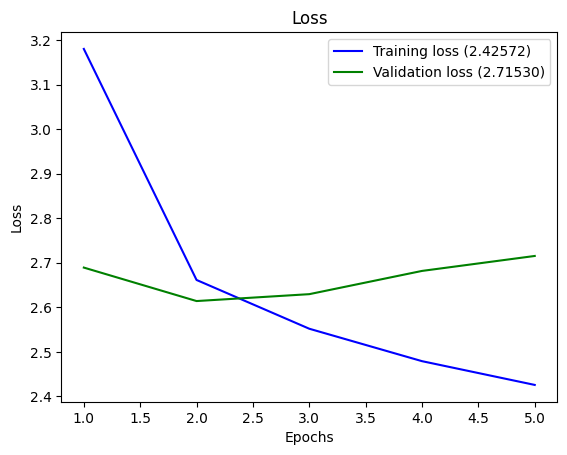

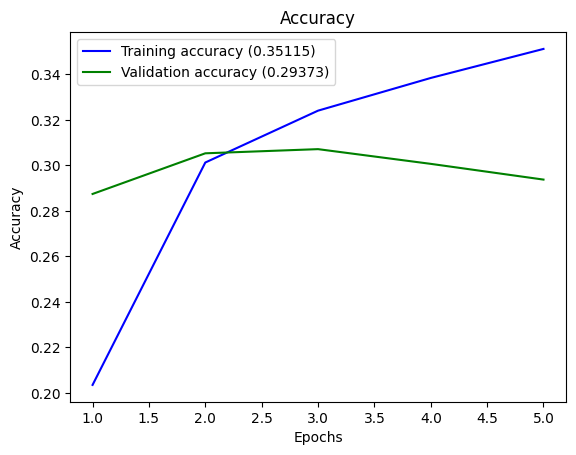

In [19]:
plot_history(history)

In [20]:
print_evaluation(model, x_test, y_test, batch_size=batch_size)

Test loss: 2.7074
Test acc: 0.3019


### Model v2 (the only difference is other activation function at the end)

In [107]:
model_name = 'tc_ml_model_2'
embedding_dim = 16
number_heads = 2
feed_forward_dim = 16
batch_size = 128
epochs = 5

In [108]:
# input layer
inputs = layers.Input(shape=(maxlen,))

# position encoding & embedding
embedding_layer = TokenAndPositionEmbedding(
    maxlen = maxlen, 
    vocab_size = max_words, 
    embed_dim = embedding_dim, 
    embed_reg = None
)
x = embedding_layer(inputs)

# multi head attention & feed forward
transformer_block = TransformerBlock(
    embed_dim = embedding_dim, 
    num_heads = number_heads, 
    ff_dim = feed_forward_dim, 
    ff_act = 'relu', 
    ff_reg = None,
    ff_d = 0.1, 
    mh_reg = None, 
    mh_d = 0.1, 
    norm_eps = 1e-3
)
x = transformer_block(x)

# # global average pooling & normalization
x = layers.GlobalAveragePooling1D()(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.25)(x)

# last layer
outputs = layers.Dense(len(dictionary), activation='softplus', kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4))(x)

# creating model
model = keras.Model(inputs=inputs, outputs=outputs)

# compile model
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.Nadam(learning_rate=0.001, clipvalue=1.0, clipnorm=1.0),
#     optimizer=optimizers.RMSprop(learning_rate=0.001, clipvalue=1.0, clipnorm=1.0),
    metrics=['acc']
)

# print model summary
model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 500)]             0         
                                                                 
 token_and_position_embeddin  (None, 500, 16)          328000    
 g_28 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_28 (Trans  (None, 500, 16)          2768      
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_28  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 layer_normalization_86 (Lay  (None, 16)               32 

In [109]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs,  
    batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    callbacks=[
        callbacks.ModelCheckpoint('../models/'+model_name+'_'+str(int(time.time()))+'_tt_'+str(tokenizer_time)+'_{epoch:02d}_{val_acc:.4f}.h5', monitor='val_acc', verbose=0, save_weights_only=False, save_best_only=True, mode='max', initial_value_threshold=0.3)
    ]
)

Epoch 1/5
1882/1882 [==============================] - 236s 124ms/step - loss: 3.5903 - acc: 0.1101 - val_loss: 3.0787 - val_acc: 0.2207
Epoch 2/5
1882/1882 [==============================] - 236s 125ms/step - loss: 2.9643 - acc: 0.2296 - val_loss: 2.7544 - val_acc: 0.2747
Epoch 3/5
1882/1882 [==============================] - 237s 126ms/step - loss: 2.7996 - acc: 0.2665 - val_loss: 2.6848 - val_acc: 0.2867
Epoch 4/5
1882/1882 [==============================] - 236s 125ms/step - loss: 2.7223 - acc: 0.2823 - val_loss: 2.6640 - val_acc: 0.2941
Epoch 5/5
1882/1882 [==============================] - 237s 126ms/step - loss: 2.6697 - acc: 0.2930 - val_loss: 2.6713 - val_acc: 0.2945


In [111]:
model.save(f'../models/{model_name}_{int(time.time())}_tt_{tokenizer_time}.h5')

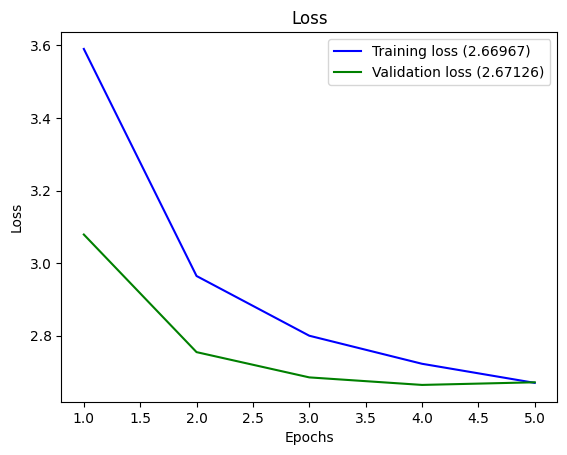

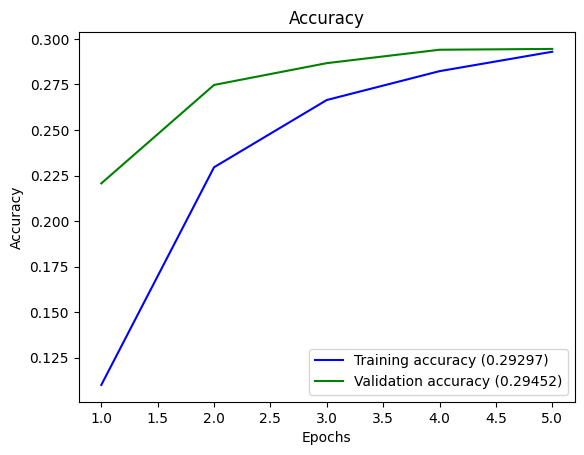

In [112]:
plot_history(history)

In [113]:
print_evaluation(model, x_test, y_test, batch_size=batch_size)

Test loss: 2.6703
Test acc: 0.2956
